In [ ]:
# 0. Define business problem

# DEMAND PREDICTION for Capital Bikeshare- Washington, D.C 

# Public bicycle sharing (PBS) systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. 
# Using these systems, people are able rent a bicycle from a one location and return it to a different place on an as-needed basis.

# In this exercise purpose has been to predict demand for PBS system services in Washington, D.C depending on meteorological data.
# Of particular interest has been identification of conditions in which traffic would be low enough and weather mild enough to allow for PBS system maintenance works.   

,weather,temp,humidity,windspeed,count
0,1,9.84,81,0.0000,16.0
1,1,9.02,80,0.0000,40.0
2,1,9.02,80,0.0000,32.0
3,1,9.84,75,0.0000,13.0
4,1,9.84,75,0.0000,1.0
...,...,...,...,...,...
10881,1,15.58,50,26.0027,336.0
10882,1,14.76,57,15.0013,241.0
10883,1,13.94,61,15.0013,168.0
10884,1,13.94,61,6.0032,129.0


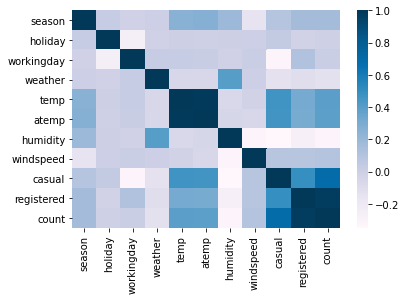

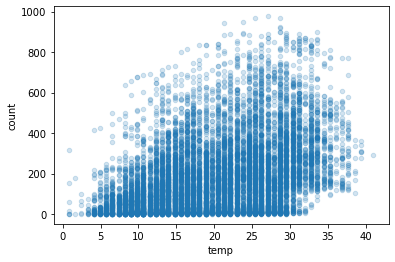

In [2]:
# 1. Load required libraries 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import pickle

# 2. Collect and prepare data

# Load the data 
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/bikeshare.csv' 
bikes = pd.read_csv(url) # original data taken from Kaggle: https://www.kaggle.com/c/bike-sharing-demand/data

# Review data
sns.heatmap(bikes.corr(), annot= False, cmap='PuBu')
bikes.plot(kind='scatter', x='temp', y='count', alpha=0.2)

# Clean data: 

# a) 
bikes= bikes.dropna(axis=0, how='any', thresh=None, subset=['count'], inplace=False) # missing values 
bikes['count']=np.where(bikes['count']<0,bikes['count'].mean(),bikes['count']) # incorect values 
# b)
bikes = bikes.drop_duplicates(['datetime']) # duplicates
# c)
bikes.drop(['registered','casual','datetime','season','holiday','workingday','atemp'], axis = 1, inplace = True) # redundant columns

bikes


In [10]:
# 3. Define model variables

# Define response variable
Y = bikes['count'] 

# Define predictor variables
feature_cols = ['temp','humidity','windspeed','weather'] 
X = bikes[feature_cols] # subsetting our data to only the predictors

In [15]:
# 4. Define baseline ML model

X_train, X_test, Y_train, Y_test = train_test_split(X, Y) # split the data into training and testing sets

linreg = LinearRegression() #instantiate a new LR model
linreg.fit(X_train, Y_train) 
Y_lr = linreg.predict(X_test) 

rf = RandomForestRegressor(max_depth=4) #instantiate a new RF model
rf.fit(X_train, Y_train) 
Y_rf = rf.predict(X_test) 

In [16]:
# 5. Interpret ML model

# Evaluate the null model
average_bike_rental = bikes['count'].mean()
average_bike_rental
num_rows = bikes.shape[0]
num_rows
null_model_predictions = [average_bike_rental]*num_rows
null_model_predictions
print('nullRMSE is', np.sqrt(metrics.mean_squared_error(Y, null_model_predictions)))

# Evaluate baseline ML models
print('lrRMSE is', np.sqrt(metrics.mean_squared_error(Y_test, Y_lr))) # RMSE
print('rfRMSE is', np.sqrt(metrics.mean_squared_error(Y_test, Y_rf))) # RMSE

# Print linear model parameters
print('LR intercept is',linreg.intercept_) # our linear Beta_0
result = zip(feature_cols, linreg.coef_) # pair the feature names with the LR coefficients
resultSet = set(result)
print('LR coefficients are', resultSet)

nullRMSE is 181.1361335742659
lrRMSE is 155.21044274720458
rfRMSE is 151.62172007098377
LR intercept is 179.25675411968348
LR coefficients are {('windspeed', 0.250740066292944), ('humidity', -2.7681208951284626), ('temp', 8.685809905627627), ('weather', 3.1121433116309816)}


In [17]:
# Store results in a dataframe
TestingData=pd.DataFrame()
TestingData['lr_prediction']=Y_lr
TestingData['rf_prediction']=Y_rf
TestingData['demand']=Y_test
features= ['temp','humidity','windspeed','weather']
TestingData[features]= X_test

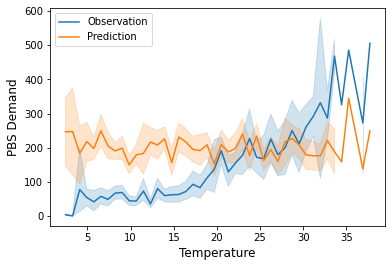

In [18]:
# Visualize results 
sns.lineplot(data=TestingData, x="temp", y="demand").set_xlabel("Temperature", fontsize = 12)
sns.lineplot(data=TestingData, x="temp", y="rf_prediction").set_ylabel("PBS Demand", fontsize = 12)
plt.legend(labels=["Observation","Prediction"])

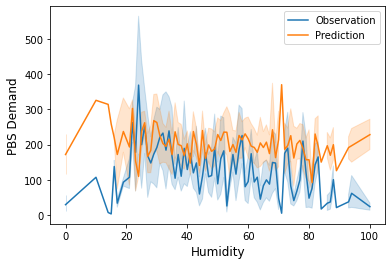

In [19]:
sns.lineplot(data=TestingData, x="humidity", y="demand").set_xlabel("Humidity", fontsize = 12)
sns.lineplot(data=TestingData, x="humidity", y="rf_prediction").set_ylabel("PBS Demand", fontsize = 12)
plt.legend(labels=["Observation","Prediction"])

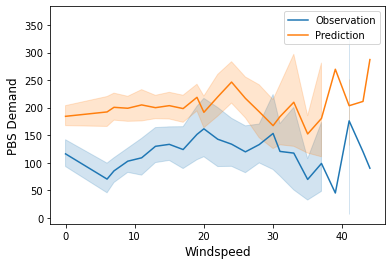

In [20]:
sns.lineplot(data=TestingData, x="windspeed", y="demand").set_xlabel("Windspeed", fontsize = 12)
sns.lineplot(data=TestingData, x="windspeed", y="rf_prediction").set_ylabel("PBS Demand", fontsize = 12)
plt.legend(labels=["Observation","Prediction"])

In [22]:
# 6. Optimize ML model

# Feature selection

k_best=[1, 2, 3, 4]

for no_features in k_best: # find best number of features
    fs = SelectKBest(score_func=f_regression, k=no_features) # define filtering method
    X_selected = fs.fit_transform(X, Y) # apply feature selection
    X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y) # split the data into training and testing sets
    rf2 = RandomForestRegressor(max_depth=4) #instantiate a new RF model
    rf2.fit(X_train, Y_train) 
    Y_rf2 = rf2.predict(X_test)
    print('for k_best =',no_features, 'rf2RMSE is', np.sqrt(metrics.mean_squared_error(Y_test, Y_rf2))) 

for k_best = 1 rf2RMSE is 163.7432204875071
for k_best = 2 rf2RMSE is 152.99536773973324
for k_best = 3 rf2RMSE is 151.22039410837033
for k_best = 4 rf2RMSE is 156.9297865550834


In [23]:
fs = SelectKBest(score_func=f_regression, k=3) # apply best number of features
X_selected = fs.fit_transform(X, Y) # apply feature selection 
print(X_selected)

[[ 9.84 81.    1.  ]
 [ 9.02 80.    1.  ]
 [ 9.02 80.    1.  ]
 ...
 [13.94 61.    1.  ]
 [13.94 61.    1.  ]
 [13.12 66.    1.  ]]


In [11]:
# Hyperparameter tuning

rf3 = RandomForestRegressor() # instantiate a new RF model

Parameter_Trials={'max_depth':[2,4,6,8,16,32,64,None], # list all the parameters to try
                  'n_estimators': [100,200,400,600,800,1000,1600],
                  'max_features':['auto', 'log2']
                 }

def Accuracy_Score(orig,pred): # define model scoring method
    RMSE = np.sqrt(metrics.mean_squared_error(orig, pred))
    print('#'*3,'Error:', RMSE)
    return(RMSE)
custom_Scoring=make_scorer(Accuracy_Score, greater_is_better=False)


grid_search=GridSearchCV(estimator=rf3, # create the Grid search space
                        param_grid=Parameter_Trials, 
                         scoring=custom_Scoring, 
                        cv=5)

grid_search.fit(X_selected,Y) # run Grid Search on feature filtered data

print('### Printing Best parameters ###')
grid_search.best_params_

### Error: 127.64233266495279
### Error: 158.64248311492838
### Error: 119.7059526830695
### Error: 208.17802224866074
### Error: 217.64773609489615
### Error: 127.43370182548568
### Error: 158.21521182400232
### Error: 119.86069949519087
### Error: 208.08680120067203
### Error: 217.7506384356672
### Error: 127.38848825131672
### Error: 158.19095585043493
### Error: 119.79209065460687
### Error: 207.91568973493582
### Error: 217.7152062559144
### Error: 139.39162905039748
### Error: 146.20968542928475
### Error: 124.61499883545403
### Error: 215.9120091739574
### Error: 222.56017158618442
### Error: 138.62156259857605
### Error: 144.8139510525592
### Error: 124.22659183899962
### Error: 216.70177947332346
### Error: 222.44536002342164
### Error: 138.11267442488207
### Error: 145.18700555981323
### Error: 124.11868992948511
### Error: 216.0200195417889
### Error: 222.13556676254308
### Error: 116.8603870309379
### Error: 157.77476121419878
### Error: 116.51738031139473
### Error: 196.85

{'max_depth': 4, 'max_features': 'auto', 'n_estimators': 400}

In [24]:
# 7. Save ML model 

# Define a best performing ML model
rf_best = RandomForestRegressor(max_depth=4, max_features='auto', n_estimators=400) 
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y) # split the data into training and testing sets
rf_best.fit(X_train, Y_train)

# Deploy as an independent application
filename = 'Capital Bikeshare_demand_prediction.sav'
pickle.dump(rf_best, open(filename, 'wb')) 

In [25]:
# 8. Use the ML model 

loaded_model = pickle.load(open(filename, 'rb'))
summer_cond = [[27.2, 83, 1]] # based on meteorological data confirm that traffic is low enough to perform PBS maintenance works
result1 = loaded_model.predict(summer_cond)
spring_cond = [[14.6, 72, 1]] # based on meteorological data confirm that traffic is low enough to perform PBS maintenance works
result2 = loaded_model.predict(spring_cond) 
print(result1)
print(result2)

[141.35094373]
[140.36324894]
